# Flow over a Circular Cylinder

### In this notebook, we will look into the simulation of flow over a circular cylinder using vortex methods. Here, in implementing the simulation, we make use of Chorin blobs, Linear Panel method and Random Vortex Method for diffusion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
%matplotlib inline

In [2]:
class Panel:
    def __init__(self, z1, z2):
        self.z1 = z1
        self.z2 = z2
        self.zc = (z1 + z2)*0.5
        self.length = abs(z2 - z1)
        self.angle = np.angle(z2 - z1)
        self.gamma = 0.0
        self.normal = np.exp(1.0j*(np.pi*0.5 + np.angle(z2 - z1)))
        if (z2.real - z2.imag)<0:
            self.angle = math.acos((z2.imag - z1.imag)/self.length)
        else:
            self.angle = math.pi + math.acos(-(z2.imag - z1.imag)/self.length)

In [3]:
def create_panels(N, R=1.0):
    panels = np.empty(N, dtype=object)
    theta = np.linspace(0, 2*np.pi, N+1)
    position = R * np.exp(1j*theta)
    for i in range(N):
        panels[i] = Panel(position[i], position[i+1])
    return panels

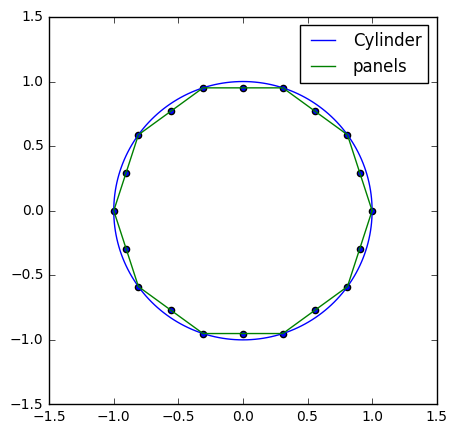

In [4]:
R = 1.0
panels = create_panels(N=10, R=1.0)
theta = np.linspace(0, 2*np.pi, 201)
x_cylinder = R*np.cos(theta)
y_cylinder = R*np.sin(theta)
plt.figure(figsize=(5,5))
plt.plot(x_cylinder, y_cylinder, label='Cylinder')
x = R*np.cos(np.linspace(0, 2*np.pi, 11))
y = R*np.sin(np.linspace(0, 2*np.pi, 11))
plt.plot(x, y, label='panels')
plt.scatter([p.z1.real for p in panels], [p.z1.imag for p in panels])
plt.scatter([p.zc.real for p in panels], [p.zc.imag for p in panels])
plt.legend()
plt.show()

In [5]:
def random_vortex_method(mu, nu, dt, N):
    sigma = np.sqrt(2*nu*dt)
    z = np.random.normal(mu, sigma, N) + 1j * np.random.normal(mu, sigma, N)
    return z

In [6]:
def compute_A(N=20, R=1.0):
    panels = create_panels(N=N, R=R)
    A = np.empty((N+1, N), dtype=float)
    np.fill_diagonal(A,0.0)
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            theta = cmath.phase(p_j.z2 - p_j.z1)
            theta1 = cmath.phase(panels[j-1].z2 - panels[j-1].z1)
            zr = (p_i.zc - p_j.z1)*np.exp(-1j*theta)
            zl = (p_i.zc - panels[j-1].z1)*np.exp(-1j*theta1)
            l = abs(p_i.z1 - p_i.z2)
            vel_l = np.conj((1j/(2.*np.pi))*(np.log((zl - l)/zl)*(zl/l) + 1.))*np.exp(1j*theta1)
            vel_r = np.conj((-1j/(2.*np.pi))*(np.log((zr - l)/zr)*(zr/l - 1.) + 1.))*np.exp(1j*theta)
            A[i][j] = ((vel_l + vel_r)*(np.exp(-1j*(p_i.angle - np.pi)))).real
            A[N,i] = 1.0
    return A

In [7]:
def compute_B(N, R, vortex_position, gamma_vortex, u_inf=1.0+0.0*1j, u_body=0.0+0.0*1j):
    panels = create_panels(N, R)
    B = np.zeros([N+1, 1], dtype=float)
    for i in range(N):
        u_body = (u_body.conjugate()*panels[i].normal).real
        u_freestream = (u_inf.conjugate()*panels[i].normal).real
        v = 0.0 + 0.0*1j
        for j,z_j in enumerate(vortex_position):
            v += vortex_velocity(panels[i].zc, vortex_position[j], gamma_vortex[j], 0.1)
        v = (v.conjugate()*panels[i].normal).real
        B[i] = u_body - u_freestream - v
    return B

### We have used chorin blob in the study. The core radius for the blob is taken to be 0.1

## Velocity Functions

In [104]:
def vortex_velocity(z, vor, gamma, delta=0.1):
    kr = get_kr(z, vor, delta)
    return (-1.0j*gamma/(2.0*np.pi*(z - vor))*kr).conjugate()

def get_kr(z, vor, delta):
    r = abs(z- vor)
    if r < delta:
        if r < 1e-10:
            return 0.0
        else:
            return r/delta
    else:
        return 1.0

def velocity_vortices(pos, gamma):
    vel = np.zeros_like(pos) + 1.0j*np.zeros_like(pos)
    for i, z_i in enumerate(pos):
        for j, z_j in enumerate(pos):
            if i!= j:
                vel[i] = vel[i] + vortex_velocity(z_i,z_j,gamma[j],0.1)
    return np.asarray(vel)

def velocity_panels(pos, panels):
    vel = []
    for i, z_i in enumerate(pos):
        v = 0.0 + 0.0j
        for j,p_j in enumerate(panels):
            v = v + panel_velocity(panels, p_j, j, z_i)
        vel.append(v)
    return np.asarray(vel)

def panel_velocity(panels, p_i, j, z):
    gamma = panels[j].gamma
    theta = cmath.phase(panels[j].z2 - panels[j].z1)
    theta1 = cmath.phase(panels[j-1].z2 - panels[j-1].z1)
    zr = (z - panels[j].z1)*np.exp(-1j*theta)
    zl = (z - panels[j-1].z1)*np.exp(-1j*theta1)
    l = abs(p_i.z1 - p_i.z2)
    vel_l = np.conj((1j/(2.*np.pi))*(np.log((zl - l)/zl)*(zl/l) + 1.))*np.exp(1j*theta1)
    vel_r = np.conj((-1j/(2.*np.pi))*(np.log((zr - l)/zr)*(zr/l - 1.) + 1.))*np.exp(1j*theta)
    return (vel_l + vel_r) * gamma

def velocity_vortices1(z, vortex_position, gamma_vortex):
    vel = np.zeros_like(z) + 1.0j*np.zeros_like(z)
    for i, v_i in enumerate(z):
        for j, v_j in enumerate(vortex_position):
            if v_i != v_j:
                vel[i] += vortex_velocity(v_i, v_j, gamma_vortex[j], 0.1)
    return np.asarray(vel)


def velocity_point(z, gamma_vortex, vortex_position, panels):
    n = len(z)
    vel = []
    for i in range(n):
        v1 = velocity_panels(z[i], panels)
        v2 = velocity_vortices1(z[i], vortex_position, gamma_vortex)
        vel.append(v1+v2)
    return np.asarray(vel)


def reflect_blobs(z, R):
    z1 = []
    for i in range(len(z)):
        if(abs(z[i]) < R):
            z1.append((2.0*R - abs(z[i]))*np.exp(1.0j*np.angle(z[i])))
        else:
            z1.append(z[i])
    return z1


### We habe made use of 30 panels and have tried with different panels and dt=0.1 seconds.

In [87]:
def flow_cylinder(dt=0.1, tf=1.0, R=1.0, N=30, Re=1000.0, u_inf=1.0+0.0*1j, gamma_max=0.1, mu=0.0):
    panels = create_panels(N, R)
    A = compute_A(N, R)
    vortex_position = np.asarray([])
    gamma_vortex = []
    momentum = np.asarray([0.0])
    nu = (2.0*abs(u_inf)*R/Re)
    t = 0.0
    delta = abs(panels[0].length)/np.pi
    while t <= tf:
        B = compute_B(N, R, vortex_position, gamma_vortex, u_inf=1.0+0.0*1j, u_body=0.0+0.0*1j)
        gamma1 = np.linalg.lstsq(A,B)[0]
        gamma1 = np.ravel(gamma1)
        for i,p in enumerate(panels):
            p.gamma = gamma1[i]
        vel = u_inf + velocity_vortices(vortex_position, gamma_vortex) + velocity_panels(vortex_position, panels)
        midpos = np.asarray(vortex_position) + vel*dt/2.
        B = compute_B(N, R, midpos, gamma_vortex, u_inf=1.0+0.0*1j, u_body=0.0+0.0*1j)
        gamma2 = np.linalg.lstsq(A,B)[0]
        gamma2 = np.ravel(gamma2)
        for i,p in enumerate(panels):
            p.gamma = gamma2[i]
        midv = u_inf + velocity_vortices(midpos, gamma_vortex) + velocity_panels(midpos, panels)
        vortex_position = np.asarray(vortex_position) + midv*dt
        for i,p in enumerate(panels):
            p.gamma = gamma1[i]
        for i,p_i in enumerate(panels):
            gamma3 = (panels[i].gamma + panels[(i+1)%len(panels)].gamma)*p_i.length/2.0
            if abs(gamma3) > gamma_max:
                nd = int(round(abs(gamma3)/gamma_max,2))
                x = np.asarray([p_i.zc + delta*p_i.normal]*nd)
                vortex_position = (np.concatenate([vortex_position, x]))
                gamma4 = np.asarray([np.sign(gamma3)*gamma_max]*nd)
                gamma_vortex = np.concatenate([gamma_vortex, gamma4])
        vortex_position = vortex_position + random_vortex_method(mu,nu,dt,len(vortex_position))
        vortex_position = reflect_blobs(vortex_position, R)
        t = t + dt
        #print t
        m = 0.0
        for i,z_i in enumerate(vortex_position):
            m = m + gamma_vortex[i]*z_i.imag
        momentum = np.concatenate([momentum,[m]])
    return vortex_position, gamma_vortex, panels, momentum

In [61]:
def plot(gamma_vortex, vortex_position, tf):
    positive_vortices = []
    negative_vortices = []
    for i,gam in enumerate(gamma_vortex):
        if gam > 0:
            positive_vortices.append(vortex_position[i])
        else:
            negative_vortices.append(vortex_position[i])
    positive_vortices = np.array(positive_vortices)
    negative_vortices = np.array(negative_vortices)
    plt.figure(figsize = (5.0,5.0))
    plt.plot(positive_vortices.real,positive_vortices.imag,"bo",label='Positive')
    plt.plot(negative_vortices.real,negative_vortices.imag,"ro",label='Negative')
    theta = np.linspace(0, 2*np.pi, 201)
    x_cylinder = R*np.cos(theta)
    y_cylinder = R*np.sin(theta)
    plt.plot(x_cylinder, y_cylinder,label='Cylinder')
    plt.legend()
    plt.title("Vortices at t=" + str(tf) + ' seconds')
    plt.axis([-4.0,4.0,-4.0,4.0])
    plt.show()

In [111]:
def velocity_contour(gamma_vortex, vortex_position, panels, tf, u_inf=1.0+1j*0.0, R=1.0):
    x,y = np.mgrid[-2.:2.:51j,-2.:2.:51j]
    z = x + 1.0j*y
    v = abs(u_inf + velocity_point(z, gamma_vortex, vortex_position, panels))
    for ii, i in enumerate(z):
        for jj,j in enumerate(i):
            if abs(j) < R:
                v[ii][jj] = 0.0
    plt.figure(figsize =(10.0,10.0))
    plt.subplot(221)
    plt.contour(x,y,v,50,linewidths=0.5)
    plt.colorbar()
    plt.subplot(222)
    plt.contourf(x,y,v,50,cmap=plt.cm.jet)
    plt.colorbar()
    x,y = np.mgrid[-2.:2.:51j,-2.:2.:51j]
    z = x + 1.0j*y
    v = abs(u_inf + velocity_point(z, gamma_vortex, vortex_position, panels))
    for ii,i in enumerate(z):
        for jj,j in enumerate(i):
            if abs(j) < R or j.real<0:
                v[ii][jj] = 0.0
    plt.subplot(223)
    plt.contour(x,y,v,50,linewidths=0.5)
    plt.colorbar()
    plt.subplot(224)
    plt.contourf(x,y,v,50)
    plt.colorbar()
    plt.suptitle('Velocity contours at t = ' + str(tf) + ' seconds', fontweight='bold', fontsize=16)
    plt.show()

In [112]:
def compute_drag(momentum, dt=0.1, tf=1.0, R=1.0, u_inf=1.0+1j*0.0):
    n = len(momentum)
    time = []
    for i in range(n-1):
        time.append(dt*(i+1))
    drag = (momentum[:-1] - momentum[1:])/dt
    cd = drag/(R*abs(u_inf)*abs(u_inf))
    print len(cd), len(time)
    plt.plot(time,cd)
    plt.title('Drag coefficeint vs time')
    plt.show()

## Results

## Time t = 1s

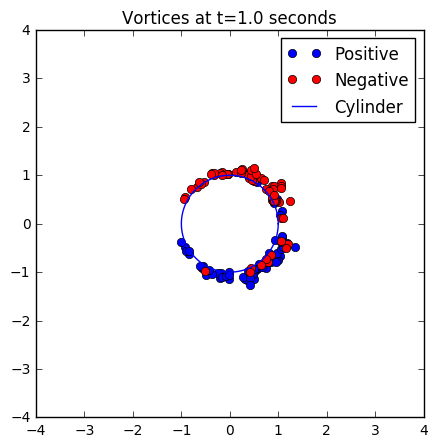

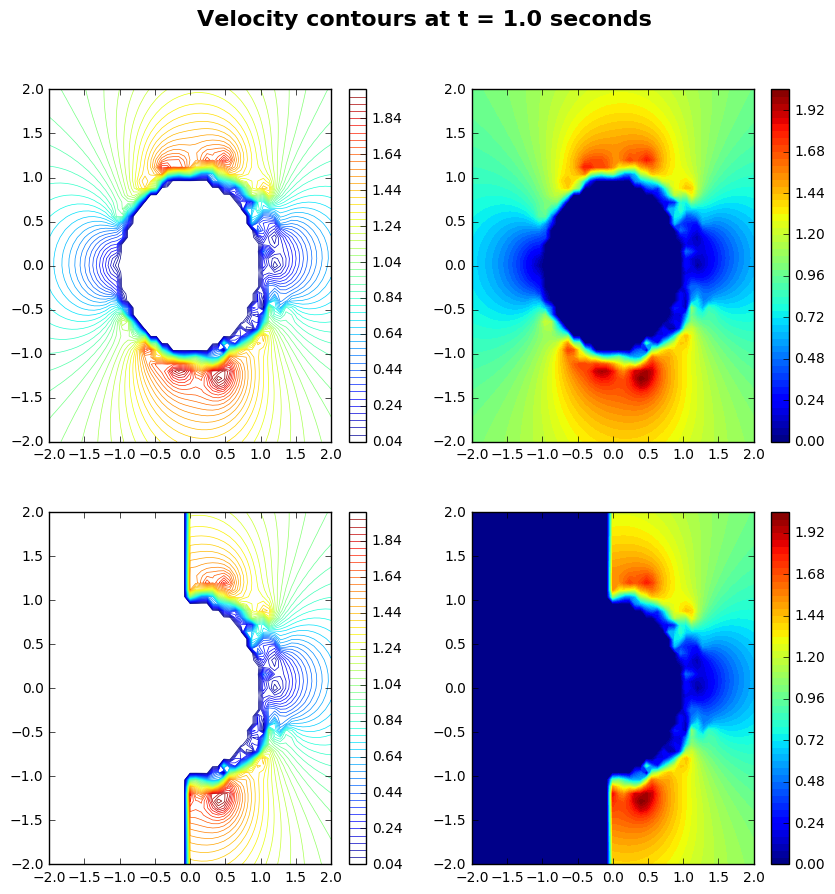

In [113]:
vortex_position, gamma_vortex, panels, momentum= flow_cylinder(tf=1.0)
plot(gamma_vortex, vortex_position,1.0)
velocity_contour(gamma_vortex, vortex_position, panels, 1.0)

## Time t = 2s

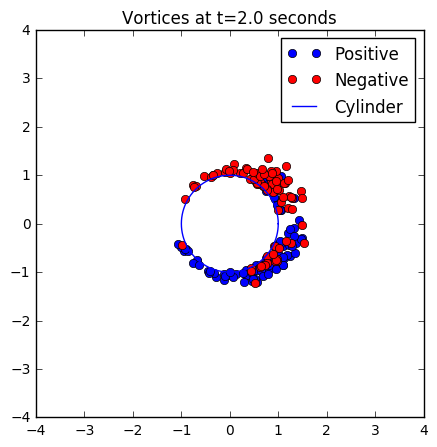

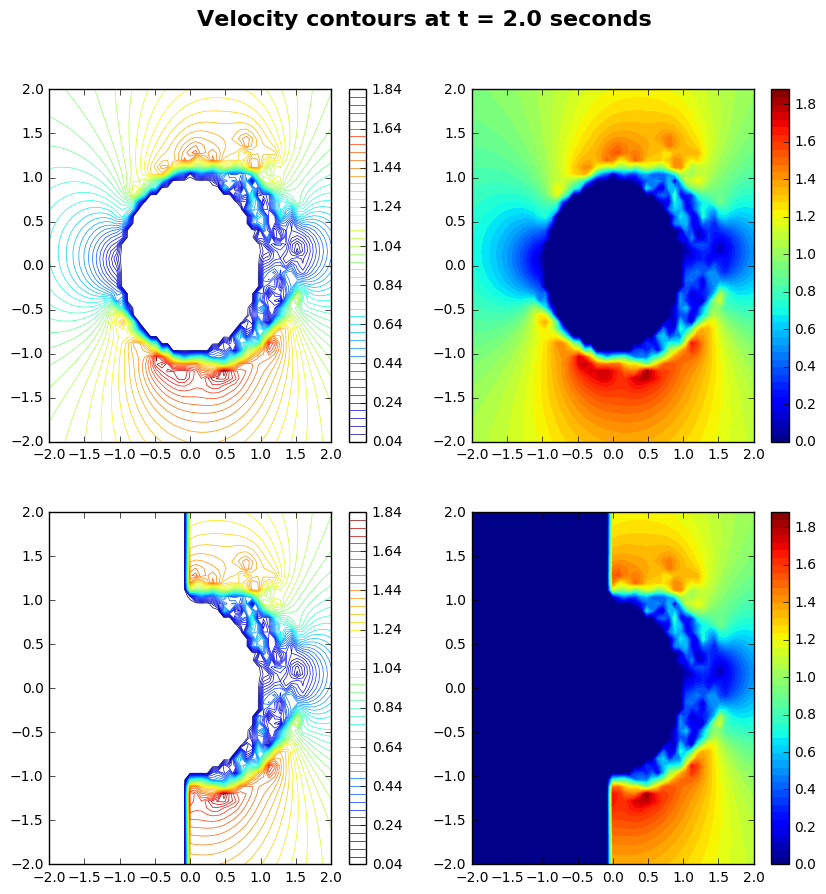

In [94]:
vortex_position, gamma_vortex, panels, momentum = flow_cylinder(tf=2.0)
plot(gamma_vortex, vortex_position,2.0)
velocity_contour(gamma_vortex, vortex_position, panels, 2.0)

## Time t=3s

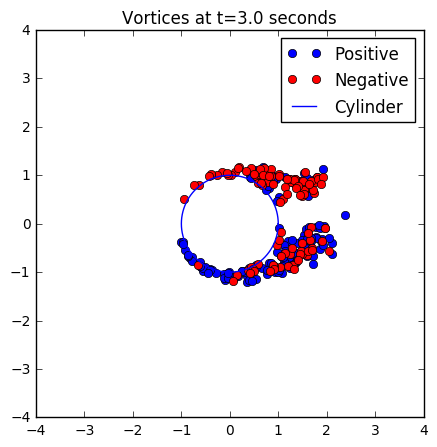

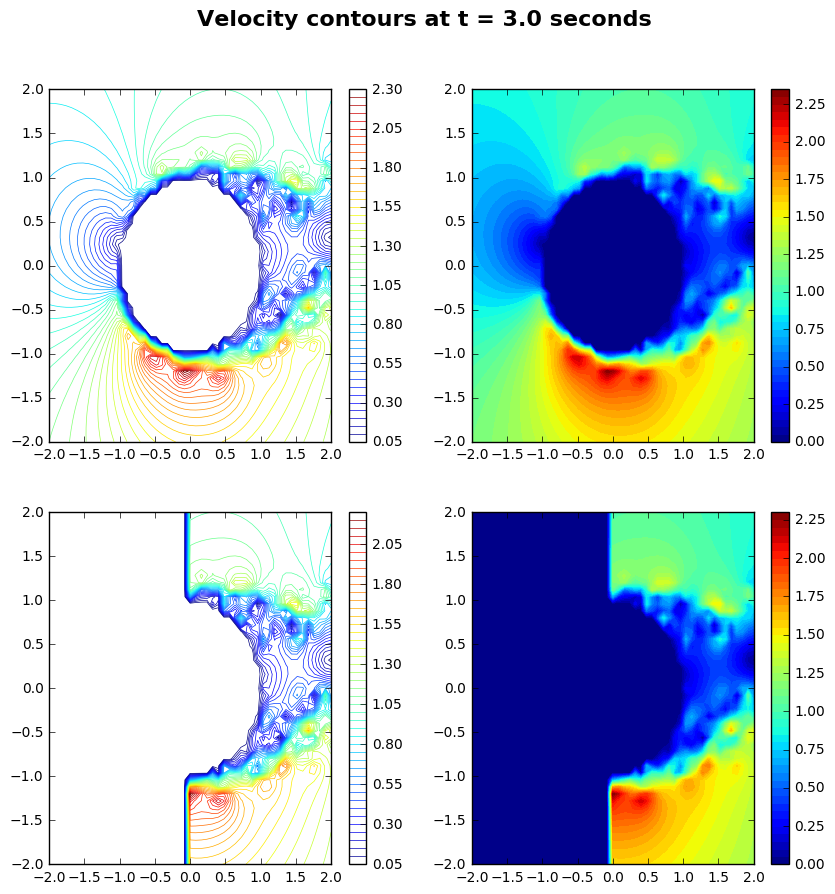

In [95]:
vortex_position, gamma_vortex, panels, momentum = flow_cylinder(tf=3.0)
plot(gamma_vortex, vortex_position,3.0)
velocity_contour(gamma_vortex, vortex_position, panels, 3.0)

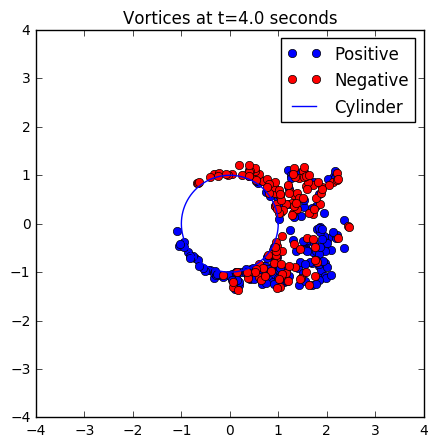

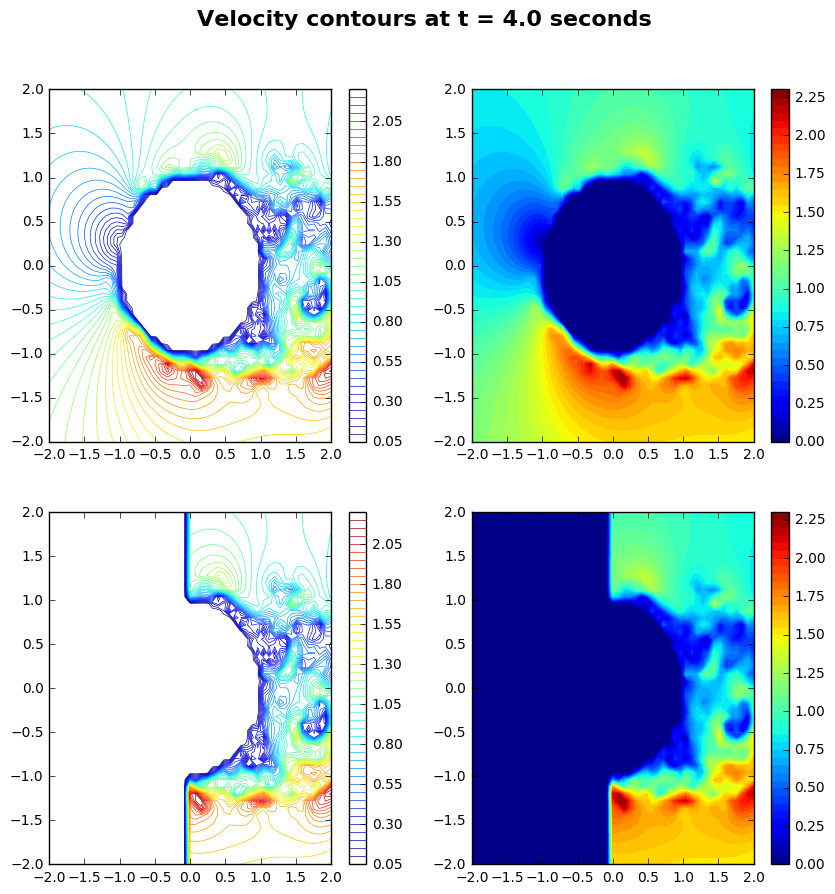

In [98]:
vortex_position, gamma_vortex, panels, momentum = flow_cylinder(tf=4.0)
plot(gamma_vortex, vortex_position,4.0)
velocity_contour(gamma_vortex, vortex_position, panels, 4.0)

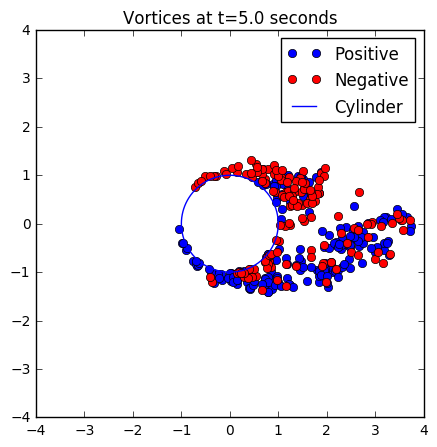

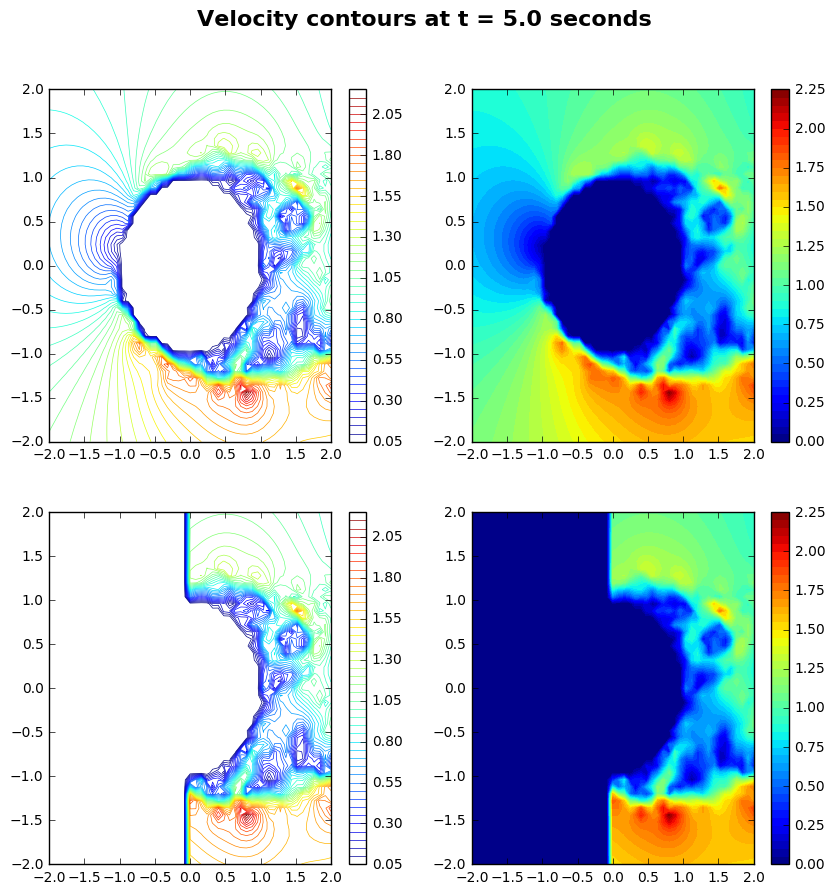

In [100]:
vortex_position, gamma_vortex, panels, momentum = flow_cylinder(tf=5.0)
plot(gamma_vortex, vortex_position,5.0)
velocity_contour(gamma_vortex, vortex_position, panels, 5.0)

# Drag

There is a net Drag resulting due to the flow across the circular cylinder. The drag is computed by taking derivative of the vortex momentum which is given by cross product of position vector and vorticity.

51 51


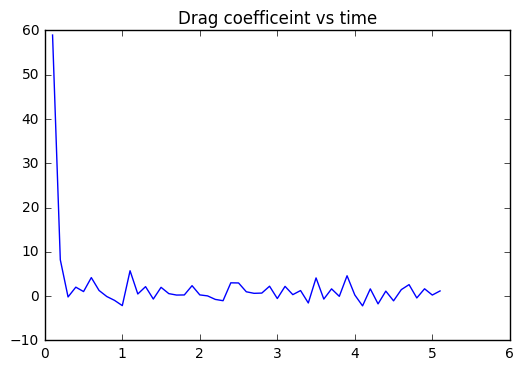

In [92]:
vortex_position, gamma_vortex, panels, momentum = flow_cylinder(tf=5.0)
compute_drag(momentum)

From the above plot, we can clearly see that the drag has reduced substantially as the flow starts. But after certain time, the drag tends to oscillate along a value. This is in good realtion with the experimental resutls, in which we observe vortex shedding beyond cylinder. The Strouhal number is a non-dimensional quantity signifying the frequency of the oscillation. For reynolds number Re=1000, the strouhal number comes out to be 0.2 approximately. 
However, the drag magnitude calculated comes out to be higher than the actual values.

# Conclusions

1. The flow past circular cylinder is shown above at various time-steps.
2. The drag experienced by the cylinder is computed and it oscillates with time as time progresses.
3. Coming to the topic of time required to compute or simulate the above solution, we can say it takes around 10 seconds for simulating 1s and about 60 seconds for 5 seconds simulation. The plot is shown below.
4. The code is run on python not on pypy.

# Timestamping

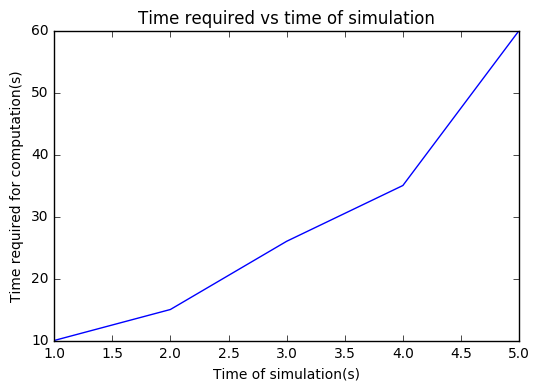

In [103]:
tf = [1, 2, 3, 4, 5]
time = [10, 15, 26, 35, 60]
plt.plot(tf, time)
plt.title('Time required vs time of simulation')
plt.xlabel('Time of simulation(s)')
plt.ylabel('Time required for computation(s)')
plt.show()